## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping
patience = [10, 25]
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for patience_es  in patience:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with EarlyStopping  Patience= %.6f" % (patience_es))
    earlystop = EarlyStopping(monitor="val_acc", 
                              patience=patience_es, 
                              verbose=1
                              )
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "EarlyStopping-Patience-%s" % str(patience_es)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Experiment with EarlyStopping  Patience= 10.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Ba

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 84us/step - loss: 2.2314 - acc: 0.2659 - val_loss: 2.0146 - val_acc: 0.3385
Epoch 2/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.7430 - acc: 0.3970 - val_loss: 1.8189 - val_acc: 0.3811
Epoch 3/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6205 - acc: 0.4351 - val_loss: 1.7015 - val_acc: 0.4102
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.5471 - acc: 0.4626 - val_loss: 1.6461 - val_acc: 0.4200
Epoch 5/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.4908 - acc: 0.4823 - val_loss: 1.6051 - val_acc: 0.4409
Epoch 6/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.4446 - acc: 0.4980 - val_loss: 1.5947 - val_acc: 0.4360
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.4061 - acc: 0.5114 - val_loss: 1.5562 - val_acc

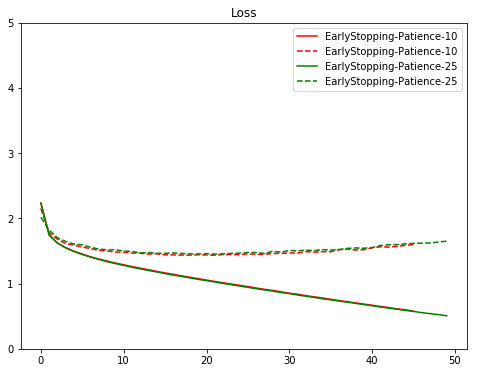

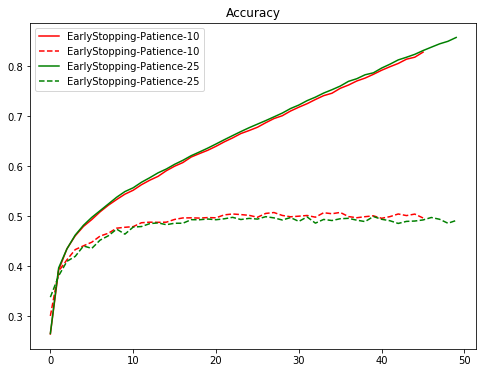

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()